In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from ae.utils import set_seed
from ae.dataset import HiddenManifold, load_mnist, load_cifar
from ae.model import AutoEncoder
from ae.trainer import Trainer
from ae.evaluation import Eval
import os
import json
import numpy as np
from matplotlib import pyplot as plt

In [2]:
chkpt_dir = "../checkpoints/cifar10-train"
get_dataset = load_cifar
torchvision_dataset = datasets.CIFAR10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model, chkpt_metadata = AutoEncoder.from_pretrained(chkpt_dir, device)
data, dataset_metadata = get_dataset(root="../data")
set_seed(0)
data = data[torch.randperm(len(data))]
print(json.dumps(chkpt_metadata, indent=2))

Files already downloaded and verified
{
  "step": 3840,
  "epoch": 15,
  "date": "2024-03-06 15:36:10",
  "optimizer": {
    "rho": 0.05,
    "adaptive": false,
    "lr": 0.0005,
    "weight_decay": 0.15,
    "betas": [
      0.9,
      0.999
    ],
    "eps": 1e-08,
    "amsgrad": false,
    "foreach": null,
    "maximize": false,
    "capturable": false,
    "differentiable": false,
    "fused": null
  },
  "architecture": {
    "input_dim": 3072,
    "hidden_layers": [
      3072,
      30
    ],
    "activation": "ReLU",
    "decoder_hidden": [
      3072
    ]
  },
  "hyperparameters": {
    "lr": 0.0005,
    "rho": 0.05,
    "batch_size": 64,
    "max_epochs": 15,
    "weight_decay": 0.15,
    "optimizer": "SAM",
    "criterion": "MSELoss",
    "scheduler": null,
    "train_size": 16384,
    "test_size": 2048,
    "train_set_percentage_for_flatness": 0.125,
    "target_loss": 0.0,
    "seed": 73,
    "compile_model": true
  },
  "device": {
    "hostname": "gnode03",
    "cpu": "

## Flatness

In [4]:
train_size = chkpt_metadata["hyperparameters"]["train_size"]
test_size = chkpt_metadata["hyperparameters"]["test_size"]
train_data = data[:train_size]
test_data = data[-test_size:]
test_loader = DataLoader(test_data, batch_size=chkpt_metadata["hyperparameters"]["batch_size"], shuffle=False)
train_loader = DataLoader(train_data, batch_size=chkpt_metadata["hyperparameters"]["batch_size"], shuffle=False)
test_loss = Eval.evaluate(model, test_loader, noise_strength=0.0)

Test loss: 0.0587 (noise: 0.0)


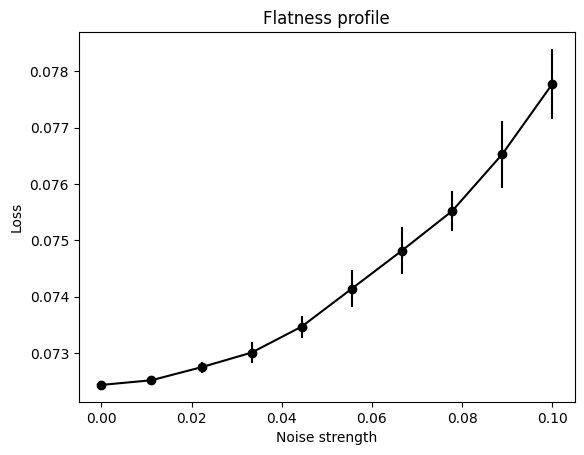

In [5]:
noise_strengths = np.linspace(0.0, 0.1, 10)
losses = Eval.flatness_profile(model, train_loader, noise_strengths, n_iters=10)
plt.title("Flatness profile")
Eval.plot_profile(losses)
plt.show()

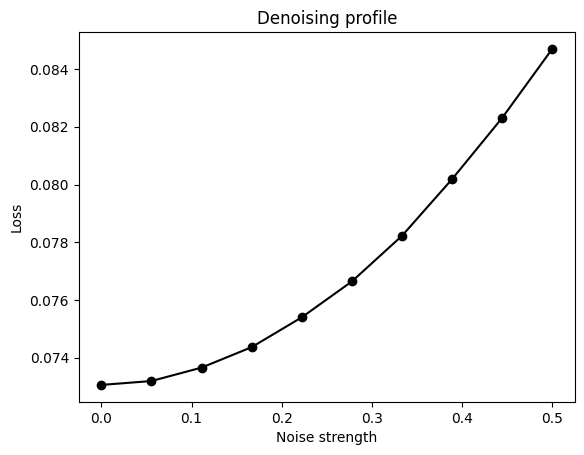

In [6]:
noise_strengths = np.linspace(0.0, 0.5, 10)
losses = Eval.denoising_profile(model, test_loader, noise_strengths, n_iters=1)
plt.title("Denoising profile")
Eval.plot_profile(losses)
plt.show()

Visualization of (some) first layer encoder weight maps


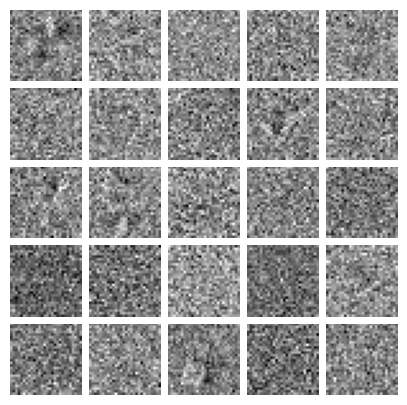

In [7]:
import numpy as np
import matplotlib.pyplot as plt

N = 5
weights = model.encoder[0].weight[:N**2].detach().cpu().numpy()

fig, axs = plt.subplots(N, N, figsize=(N, N))

for i, ax in enumerate(axs.flat):
    ax.imshow(weights[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
print("Visualization of (some) first layer encoder weight maps")
plt.show()

## Latent Space

In [5]:
dataset = torchvision_dataset(
    root="../data",
    train=False,
    download=True,
)
data = dataset.data
data = torch.tensor(dataset.data)
data = 2 * (data / 255) - 1
test_set = data.flatten(start_dim=1)
labels = dataset.targets

Files already downloaded and verified


In [6]:
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)

latent = torch.Tensor()
for idx, batch in enumerate(test_loader):
    batch = batch.to(device)
    with torch.no_grad():
        latent = torch.cat((latent, model.encode(batch)), dim=0)
latent = latent.cpu().numpy()
latent.shape

(10000, 30)

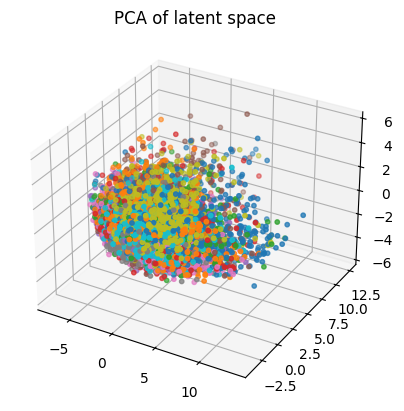

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
latent_pca = pca.fit_transform(latent)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent_pca[:, 0], latent_pca[:, 1], latent_pca[:, 2], c=labels, cmap='tab10', s=10)
plt.title("PCA of latent space")
plt.show()

In [8]:
# use tsne instead of pca
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=30, n_iter=4000)
latent_tsne = tsne.fit_transform(latent)

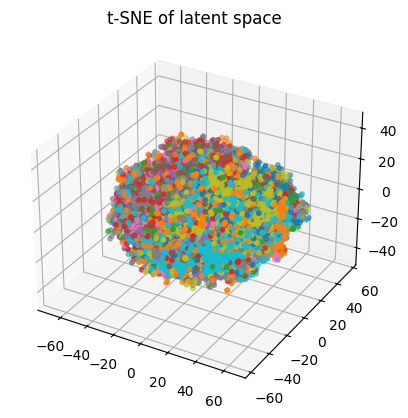

In [9]:
# plt.figure(figsize=(10, 10))
# plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10', s=10)
# plt.colorbar()
# plt.title("t-SNE of latent space")
# plt.show()
# do a 3d scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent_tsne[:, 0], latent_tsne[:, 1], latent_tsne[:, 2], c=labels, cmap='tab10', s=10)
plt.title("t-SNE of latent space")
plt.show()

In [29]:
import numpy as np

average_l2_norm = np.linalg.norm(latent, axis=1).mean()
average_l2_norm

21.294134

Decoded image for every vector of a basis of latent space


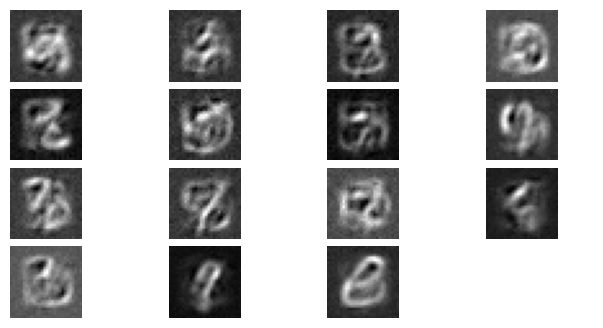

In [9]:
import math
bottleneck = model.bottleneck

with torch.no_grad():
    N = math.ceil(math.sqrt(bottleneck))
    M = math.ceil(bottleneck / N)
    fig, axs = plt.subplots(M, N, figsize=(2*M, N))

    for i, ax in enumerate(axs.flat):
        if i >= bottleneck:
            ax.axis('off')
            continue

        x = torch.zeros(bottleneck)
        x[i] = 1
        x = x.to(device)
        x = model.decoder(x).cpu().numpy().reshape(28, 28)
        ax.imshow(x, cmap='gray')
        ax.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    print("Decoded image for every vector of a basis of latent space")
    plt.show()
